In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, preprocessing
from sklearn.svm import SVC,NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from IPython.display import Image
import re
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

In [2]:
from keras.layers import Embedding, Dense, LSTM , Dropout
from keras.models import Sequential
import seaborn as sns; sns.set()

Using TensorFlow backend.


In [13]:
train = pd.read_excel("/home/pallav/Desktop/PROJECT/hindi_spam.xlsx")
print(train)

      type                                               text
0      ham  हर सामुदायिक स्तर पर ईमानदारी और कर्मठता से प्...
1      ham  प्लेयर्स को लंबे समय तक बर्फ पर चलने से खुद को...
2      ham  सज्जन! हम आपसे संपर्क करने का प्रयास कर रहे है...
3     spam  राजश्री कावेरी लॉटरी घोषित होने के आधे घंटे बा...
4      ham  धार्मिक पर्वों और उत्सवों की अभिवृद्धि के साथ-...
5      ham  स्मार्टफोन के 4जीबी रैम वेरिएंट की कीमत 10,999...
6      ham   किसी की धूर्तता, चालाकी, झूठ बात आदि से उत्पन...
7      ham  विपक्ष कमज़ोर सरकार चाहता है ताकि देश को लूटा ...
8      ham  बठिंडा में बोले सुखबीर बादल, किसानों से धोखा क...
9      ham  परिवार के लोगों को स्थानीय लोगों और दमकल कर्मि...
10     ham  दलाल स्ट्रीट की 'लेडी झुनझुनवाला' हैं डॉली खन्...
11    spam  बिजनेस के दिन पर दिन टफ होते कॉम्‍पि‍टि‍शन में...
12     ham  प्रायः सभी भारतीय पाठशालाओं में पढ़ाने का माध्...
13     ham  अभी भी देर नहीं हुई है। हिंदी को अभी भी अपने स...
14     ham  नेवले ने झट से, ज़ायदा आम लाने के लालच में बड़ी ...
15     h

Frequency of spam and ham E-Mails:
 ham     2100
spam     900
Name: type, dtype: int64


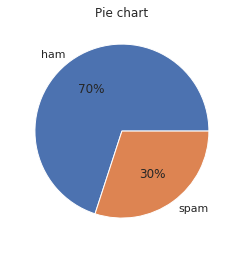

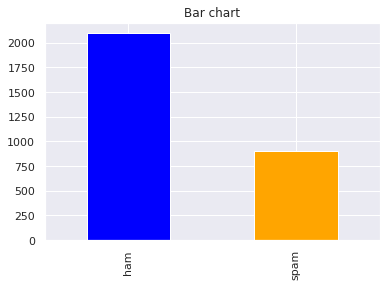

In [14]:
print("Frequency of spam and ham E-Mails:\n",train['type'].value_counts())
count_Class=pd.value_counts(train["type"], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

# REMOVING PUNCTUATIONS , DIGITS & ENGLISH LETTERS

In [15]:
def purify(doc):
    punctuations = '''!@#$£%^&*()"':-+_=“”/?><|।.,\{}[]'''
    digits = '''1234567890०१२३४५६७८९'''
    english = '''abcdefghijklmnopqrstuvwxyzABCCDEFGHIJKLMNOPQRSTUVWXYZ'''
    data_no_punc = ""
    for char in doc:
        if(char not in punctuations and char not in digits and char not in english):
            data_no_punc = data_no_punc + char
    return data_no_punc
i=0
for e in train['text']:
    train['text'][i]=''.join(list(map(purify,e)))
    train['text'][i]=train['text'][i].split()
    i=i+1

# REMOVING STOP-WORDS

In [16]:
# stopwords = open('stopwords-hi-master/stopwords-hi.txt','r')
with open('/home/pallav/Desktop/PROJECT/stopwords-hi.txt') as f:
    stopwords = f.read()
# stwords=stopwords.read()
words = re.sub('\n',' ',stopwords)
word = words.split()

def rem_stop(doc):
    clearW = [wor for wor in doc if wor not in word]
    return clearW

train['text']=list(map(rem_stop,train['text']))

# REMOVING SUFFIXES

In [17]:
suffixes = {
    1: ["ो", "े", "ू", "ु", "ी", "ि", "ा"],
    2: ["कर", "ाओ", "िए", "ाई", "ाए", "ने", "नी", "ना", "ते", "ीं", "ती","एं", "ता", "ाँ", "ां", "ों", "ें","ओं","ाना",
        "ाऊ","लु","ाव","ीय","हट"],
    3: ["ाकर", "ाइए", "ाईं", "ाया", "ेगी", "ेगा", "ोगी", "ोगे", "ाने", "ाना", "ाते", "ाती", "ाता", "तीं", "ाओं",
        "ाएं", "ुओं", "ुएं", "ुआं","दार","िया","हार","ावट","ोला","कार","ान","ौटी","ैया","ेरा","ोड़ा"],
    4: ["ाएगी", "ाएगा", "ाओगी", "ाओगे", "एंगी", "ेंगी", "एंगे", "ेंगे", "ूंगी", "ूंगा", "ातीं", "नाओं", "नाएं", "ताओं",
        "ताएं", "ियाँ", "ियों", "ियां","वाला","िक"],
    5: ["ाएंगी", "ाएंगे", "ाऊंगी", "ाऊंगा", "ाइयाँ", "ाइयों", "ाइयां","क्कड़"]
}

def hi_stem(lst):
    txt = []
    for word in lst: 
        flag = 0
        for L in 5, 4, 3, 2, 1:
            if len(word) > L + 1:
                for suf in suffixes[L]:
                    if word.endswith(suf):
                        word = word[:-L]
                        flag = 1
                        break
                if flag == 1:
                    break
        txt.append(word)      
    return txt

email = []
email = (list(map(hi_stem,train['text'])))
train['text']= email

for  i in range(0,train['text'].shape[0]):
    train['text'][i] = ' '.join(train['text'][i])

print(train)

      type                                               text
0      ham             हर सामुद स्तर ईमानदार कर्मठ प्रयास किए
1      ham                प्लेयर्स लंब समय बर्फ चल खुद बच चाह
2      ham  सज्जन संपर्क प्रयास पिछल सप्ताहांत पत चल पुरस्...
3     spam  राजश्र कावेर लॉटर घोषित आध घंट या शाम बज गोव ल...
4      ham  धार पर्व उत्सव अभिवृद्ध साथसाथ राष्ट्र अनेक इल...
5      ham  स्मार्टफोन जीब रैम वेरिएंट कीमत रुपए जीब रैम व...
6      ham           धूर्त चालाक झूठ बात उत्पन्न मिथ्य प्रतीत
7      ham                विपक्ष कमज़ोर सर चाह ताक देश लूट सक
8      ham  बठिंड बोल सुखबीर बादल किसान धोख आरोप कैप्टन दर...
9      ham  परिवार लोग स्थान लोग दमकल कर्म कूड़ ढेर बाहर न...
10     ham  दलाल स्ट्रीट लेड झुनझुन डॉल खन् सिर्फ शेयर लग पैस
11    spam  बिजनेस दिन दिन टफ कॉम्‍पि‍टि‍शन सुपरमार्केट हा...
12     ham  प्रायः भारत पाठशाल पढ़ माध्यम हिंद वर्ष पर्यंत...
13     ham                        देर हिंद सहज रूप बढ़ ज़रूरत
14     ham              नेवल झट ज़ायद आम ला लालच बड़ टोकर उठ ली
15     h

In [20]:
# train_x,valid_x,train_y,valid_y = train_test_split(train['text'],train['type'],test_size=0.2,stratify=train['type'].values,random_state=2)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train['type'])
# valid_y = encoder.fit_transform(valid_y)

In [21]:
# tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
# tfidf_vect.fit(train['text'])
# x_tfidf = tfidf_vect.transform(train.text)
# xtrain_tfidf =  tfidf_vect.transform(train_x)
# xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=10000)
train_tfid = tfidf_vect_ngram.fit_transform(train['text'])
# x_tfidf_ngram = tfidf_vect_ngram.transform(train.text)
# xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
# xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

In [22]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y),confusion_matrix(valid_y, predictions)

In [11]:
# Naive Bayes on Ngram Level TF IDF Vectors
NBAccuracy = train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", NBAccuracy)

NB, N-Gram Vectors:  (0.885, array([[390,  30],
       [ 39, 141]]))


In [12]:
# SVM SVC on Ngram Level TF IDF Vectors
SVCAccuracy = train_model(SVC(kernel='linear'),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-gram TF-IDF: ", SVCAccuracy)

SVC, N-gram TF-IDF:  (0.895, array([[404,  16],
       [ 47, 133]]))


In [13]:
# SVM NuSVC on Ngram Level TF IDF Vectors
NuSVCAccuracy = train_model(NuSVC(kernel='linear',probability=True),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-gram TF-IDF: ", NuSVCAccuracy)

SVC, N-gram TF-IDF:  (0.88, array([[414,   6],
       [ 66, 114]]))


In [14]:
# RF on n-grams Level TF IDF Vectors
RFAccuracy = train_model(RandomForestClassifier(n_estimators=250,min_samples_split=10), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("RF, N-gram TF-IDF: ", RFAccuracy)

RF, N-gram TF-IDF:  (0.8916666666666667, array([[409,  11],
       [ 54, 126]]))


In [15]:
# GB on n-grams Level TF IDF Vectors
GBAccuracy = train_model(GradientBoostingClassifier(n_estimators=250,min_samples_split=200), xtrain_tfidf_ngram.tocsc(), train_y, xvalid_tfidf_ngram.tocsc())
print("Gradient Boost, N-Grams Vectors: ", GBAccuracy)

Gradient Boost, N-Grams Vectors:  (0.88, array([[407,  13],
       [ 59, 121]]))


In [16]:
# KNN on n-grams Level TF IDF Vectors
KNNAccuracy = train_model(KNeighborsClassifier(n_neighbors=10),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("KNN, N-gram TF-IDF: ", KNNAccuracy)

KNN, N-gram TF-IDF:  (0.8866666666666667, array([[399,  21],
       [ 47, 133]]))


In [17]:
# Stacking using all above algos
Stack_Accuracy = train_model(VotingClassifier(estimators=[('SVC', SVC(kernel='linear',probability=True).fit(xtrain_tfidf_ngram, train_y)), ('RF', RandomForestClassifier(n_estimators=250,min_samples_split=3).fit(xtrain_tfidf_ngram, train_y)),('KNN',KNeighborsClassifier(n_neighbors=10).fit(xtrain_tfidf_ngram, train_y)),('NB',naive_bayes.BernoulliNB().fit(xtrain_tfidf_ngram, train_y)),('NuSVC',NuSVC(kernel='linear',probability=True).fit(xtrain_tfidf_ngram, train_y)),('GB',GradientBoostingClassifier(n_estimators=250,min_samples_split=200).fit(xtrain_tfidf_ngram, train_y))], voting='soft',weights=[6,5,4,3,2,1]), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Stacking, N-gram TF-IDF: ", Stack_Accuracy)

Stacking, N-gram TF-IDF:  (0.9033333333333333, array([[404,  16],
       [ 42, 138]]))


In [23]:
NBModel = naive_bayes.BernoulliNB().fit(x_tfidf_ngram,train['type'])
SVCModel = SVC(kernel='linear',probability=True).fit(x_tfidf_ngram,train['type'])
NuSVCModel = NuSVC(kernel='linear',probability=True).fit(x_tfidf_ngram,train['type'])
RFModel = RandomForestClassifier(n_estimators=250,min_samples_split=3).fit(x_tfidf_ngram,train['type'])
GBModel = GradientBoostingClassifier(n_estimators=250,min_samples_split=200).fit(x_tfidf_ngram,train['type'])
KNNModel = KNeighborsClassifier(n_neighbors=10).fit(x_tfidf_ngram,train['type'])
StackModel = VotingClassifier(estimators=[('SVC', SVCModel), ('RF', RFModel),('KNN',KNNModel),('NB',NBModel),('NuSVC',NuSVCModel),('GB',GBModel)], voting='soft',weights=[6,5,4,3,2,1]).fit(x_tfidf_ngram,train['type'])

In [19]:
f1 = "/home/pallav/project_work/Models/NB.sav"
pickle.dump(NBModel,open(f1,'wb'))

f2 = "/home/pallav/project_work/Models/SVC.sav"
pickle.dump(SVCModel,open(f2,'wb'))

f3 = "/home/pallav/project_work/Models/NuSVC.sav"
pickle.dump(NuSVCModel,open(f3,'wb'))

f4 = "/home/pallav/project_work/Models/RF.sav"
pickle.dump(RFModel,open(f4,'wb'))

f5 = "/home/pallav/project_work/Models/GB.sav"
pickle.dump(GBModel,open(f5,'wb'))

f6 = "/home/pallav/project_work/Models/KNN.sav"
pickle.dump(GBModel,open(f6,'wb'))

f7 = "/home/pallav/project_work/Models/Stack.sav"
pickle.dump(GBModel,open(f7,'wb'))

In [20]:
with open("Models/Stack.sav",'rb') as f17:
    load_stack = pickle.load(f17)

In [24]:
str = 'आपने लॉटरी जीती है'
str=purify(str)
print(str)
str=str.split()
str=rem_stop(str)
print(str)
str = hi_stem(str)
print(str)
str = ' '.join(str)
str

आपने लॉटरी जीती है
['लॉटरी', 'जीती']
['लॉटर', 'जी']


'लॉटर जी'

In [25]:
l = []
l.append(str)
str_tfidf_ngram = tfidf_vect_ngram.transform(l)

In [26]:
StackModel.predict(str_tfidf_ngram)

array(['spam'], dtype=object)